#計算機程式設計二
#第七週上課內容
#Calculator

### 主題: 編譯器 Compiler、詞法分析器 Lexical Analyzer、語法分析器 Parser



###參考資料:
- MIT OCW 6.01 HW1: Calculator — Fall 2011   (google MIT6_01SCS11_hw1.pdf)


- Wikipedia http://rosettacode.org/wiki/Arithmetic_Evaluator/C

- “Compiler Design in C”,  Allen Holub




這個單元的主要任務是實作出 Expression 計算機，能夠用來求出下面範例中的算式的值
```
>> x = 3
3
>> y = -5
-5
>> z = 4*x + y*-6
42
```

我們的目標是藉由實作來了解基本的詞法分析、語法分析概念，以及粗淺的編譯器設計原理。編譯器設計是資工領域的基礎科目，未來如果有機會最好選修一下，我們在這裡只能提到一些淺顯的知識。所謂編譯器，是指一種程式工具，可以用來將某種高階語言翻譯成另一種較低階語言，譬如 C Compiler 能夠將 C 語言程式翻譯成組合語言 (Assembly) 程式。C和C++ 從發明以來，語法和功能還是持續在擴充，譬如 C11 或是 C++14、C++17。我們必須使用支援新語法的編譯器，才能夠編譯包含新語法的程式碼。C 編譯器將 C 語言翻譯成組合語言之後，還要再依靠組譯器 (Assembler) 將組合語言翻譯成 Object Code ，然後由 Linker 連結其他函式庫，再載入記憶體中執行。


開始寫 Expression 計算機的程式之前，我們要先定好希望處理的 Expression。我們要先確定 Expression 中會出現哪些符號和字詞，另外就是 Expression 可以接受哪些字詞的組合，也就是所謂的語法。在這個範例中，我們假設要處理的 Expression 只有
 i) 加減乘除的運算以及
 ii) 設定變數值，
而且任何 Expression 最後經過 Evaluation ，得到的都是整數值。所以，我們要實作的計算機，只有整數型別，不論是變數還是常數都只能得到整數值，而且加減乘除的四則運算也都是整數運算。

先來處理符號和字詞。符號包含 `+ - * / =  (  )`  ，字詞則有 *整數值* 和 *變數名稱*。這個階段要做的事情通常稱做詞法分析 Lexical Analysis，需要寫出叫做 Tokenizer  的程式。我們的程式要能夠讀取一行輸入，然後把每個符號和字詞擷取出來，切成一個個 Token，每個 Token 有一個對應的代號，用一個整數值來代表。底下是以 `typedef` 定的整數列舉型別，`UNKNOWN` 對應的整數值是 `0`、`END` 對應的整數值是 `1`、`INT` 對應的整數值是 `2`、依此類推。
```
typedef enum {UNKNOWN, END, INT, ID, ADDSUB, MULDIV, ASSIGN, LPAREN, RPAREN} TokenSet;
```

所以如果輸入的 Expression 是  `2*(3+x)`，對應的 Token 就是  `INT MULDIV LPAREN INT ADDSUB ID RPAREN`，因為 `2` 對應到 `INT`、`*` 對應到 `MULDIV`、 `(` 對應到 `LPAREN`、依此類推。


除了記住 Token 的代號之外，我們也要把對應的字串記下來，存在下面的 字元陣列中
```
static char lexeme[MAXLEN];
```

接下來要寫出一個函數
```
TokenSet getToken(void);
```
每次呼叫能夠取出下一個 Token，輸入的字元如果是空白就忽略，換行字元對應的 Token 是 `END`。完整的程式碼如下：

In [ ]:
%%writefile lex.c

#include <stdio.h>
#include <ctype.h>
#include <string.h>
#include "lex.h"
static TokenSet getToken(void);
static TokenSet lookahead = UNKNOWN;
static char lexeme[MAXLEN];

TokenSet getToken(void)
{
    int i;
    char c;
    while ( (c = fgetc(stdin)) == ' ' || c== '\t' );  // 忽略空白字元
    if (isdigit(c)) {
        lexeme[0] = c;
        c = fgetc(stdin);
        i = 1;
        while (isdigit(c) && i<MAXLEN-1) {
            lexeme[i] = c;
            ++i;
            c = fgetc(stdin);
        }
        ungetc(c, stdin);
        lexeme[i] = '\0';
        return INT;
    } else if (c == '+' || c == '-') {
        lexeme[0] = c;
        lexeme[1] = '\0';
        return ADDSUB;
    } else if (c == '*' || c == '/') {
        lexeme[0] = c;
        lexeme[1] = '\0';
        return MULDIV;
    } else if (c == '\n') {
        lexeme[0] = '\0';
        return END;
    } else if (c == '=') {
        strcpy(lexeme, "=");
        return ASSIGN;
    } else if (c == '(') {
        strcpy(lexeme, "(");
        return LPAREN;
    } else if (c == ')') {
        strcpy(lexeme, ")");
        return RPAREN;
    } else if (isalpha(c) || c == '_') {
        lexeme[0] = c;
        c = fgetc(stdin);
        i = 1;
        while (isalpha(c) || isdigit(c) || c == '_') {
            lexeme[i] = c;
            ++i;
            c = fgetc(stdin);
        }
        ungetc(c, stdin);
        lexeme[i] = '\0';
        return ID;
    } else {
        return UNKNOWN;
    }
}

void advance(void)
{
    lookahead = getToken();
}

int match(TokenSet token)
{
    if (lookahead == UNKNOWN) advance();
    return token == lookahead;
}

char* getLexeme(void)
{
    return lexeme;
}

Overwriting lex.c


In [ ]:
%%writefile lex_1.c

#include <stdio.h>
#include <ctype.h>
#include <string.h>
#include "lex.h"
static TokenSet getToken(void);
static TokenSet lookahead = UNKNOWN;
static char lexeme[MAXLEN];

char myfgetc(char backup)
{
  static char stored;
  char c;
  if (backup == 0 && stored == 0) {
    c = fgetc(stdin);
  } else if (backup == 0 && stored != 0) {
    c = stored;
    stored = 0;
  } else {
    c = stored = backup;
  }

  return c;
}
TokenSet getToken(void)
{
    int i;
    char c;
    while ( (c = myfgetc(0)) == ' ' || c== '\t' );  // 忽略空白字元
    if (isdigit(c)) {
        lexeme[0] = c;
        c = myfgetc(0);
        i = 1;
        while (isdigit(c) && i<MAXLEN-1) {
            lexeme[i] = c;
            ++i;
            c = myfgetc(0);
        }
        myfgetc(c);
        lexeme[i] = '\0';
        return INT;
    } else if (c == '+' || c == '-') {
        lexeme[0] = c;
        lexeme[1] = '\0';
        return ADDSUB;
    } else if (c == '*' || c == '/') {
        lexeme[0] = c;
        lexeme[1] = '\0';
        return MULDIV;
    } else if (c == '\n') {
        lexeme[0] = '\0';
        return END;
    } else if (c == '=') {
        strcpy(lexeme, "=");
        return ASSIGN;
    } else if (c == '(') {
        strcpy(lexeme, "(");
        return LPAREN;
    } else if (c == ')') {
        strcpy(lexeme, ")");
        return RPAREN;
    } else if (isalpha(c) || c == '_') {
        lexeme[0] = c;
        c = myfgetc(0);
        i = 1;
        while (isalpha(c) || isdigit(c) || c == '_') {
            lexeme[i] = c;
            ++i;
            c = myfgetc(0);
        }
        myfgetc(c);
        lexeme[i] = '\0';
        return ID;
    } else {
        return UNKNOWN;
    }
}

void advance(void)
{
    lookahead = getToken();
}

int match(TokenSet token)
{
    if (lookahead == UNKNOWN) advance();
    return token == lookahead;
}

char* getLexeme(void)
{
    return lexeme;
}


Writing lex_1.c


In [ ]:
%%writefile lex.h

#ifndef __LEX__
#define __LEX__

#define MAXLEN 256
typedef enum {UNKNOWN, END, INT, ID, ADDSUB, MULDIV, ASSIGN,
LPAREN, RPAREN} TokenSet;

extern int match (TokenSet token);
extern void advance(void);
extern char* getLexeme(void);

#endif // __LEX__

Overwriting lex.h


程式碼寫法其實很規律，讀到特定字元，就傳回對應的 Token 代號，並且順便把內容儲存在 `lexeme` 陣列中。比較複雜的是 `INT` 和 `ID`。以 `INT` 來說，我們需要讀取一連串包含 `0` 到 `9` 的數字，所以一旦發現開頭第一個字元是數字，就繼續把後面的數字吃進來，直到遇到的字元不是數字為止。由於最後多吃了一個字元 (因為不是數字而跳出 `while` 迴圈)，所以必須用 `ungetc` 把那個多讀到的字元吐回去。至於 `ID` 我們允許的變數名稱和 C 語言一樣，可以是由英文字母或是 底線 `_` 開頭，後面可以接更多英文字母或是數字或是底線，例如 `x, y, Mobile01, Gran_Torino`。

實際上我們會把 `getToken` 隱藏起來，後續的程式碼並不會直接呼叫 `getToken`，而是透過底下的兩個函數來讀取和判斷目前的 Token：
```
void advance(void)
{
    lookahead = getToken();
}

int match(TokenSet token)
{
    if (lookahead == UNKNOWN) advance();
    return token == lookahead;
}
```

呼叫 `advance()` 就會讀取下一個 Token，讀取到的 Token 會儲存在全域變數 `lookahead` ，它的宣告如下：
```
static TokenSet lookahead = UNKNOWN;
```

呼叫 `match(token)` 並且傳入希望判斷的 Token，就會比對目前記錄在 `lookahead` 的 Token 和預期的 Token是否相同。在第一次呼叫 `match` 的時候，由於 `lookahead` 是 `UNKNOWN`，所以會先呼叫 `advance` 取得 Token。
        
        
由於我們把 `lexeme` 也隱藏起來，所以還需要底下的函數，讓外部的程式碼可以讀取 `lexeme`
```
char* getLexeme(void)
{
    return lexeme;
}
```
我們拿底下的程式碼測試一下是否可以正確運作。

In [ ]:
%%writefile E07_01.c
#include <stdio.h>
#include "lex.h"

int main(void)
{
    advance();
    printf("%d: %s\n", match(INT), getLexeme());
    printf("%d: %s\n", match(ID), getLexeme());
    printf("%d: %s\n", match(ADDSUB), getLexeme());
    advance();
    printf("%d: %s\n", match(MULDIV), getLexeme());
    advance();
    printf("%d: %s\n", match(LPAREN), getLexeme());
    advance();
    printf("%d: %s\n", match(ID), getLexeme());
    advance();
    printf("%d: %s\n", match(ADDSUB), getLexeme());
    advance();
    printf("%d: %s\n", match(INT), getLexeme());
    advance();
    printf("%d: %s\n", match(RPAREN), getLexeme());

    return 0;
}

Overwriting E07_01.c


In [ ]:
%%shell
gcc lex_1.c E07_01.c -o E07_01
./E07_01

123*(num0-100)
1: 123
0: 123
0: 123
1: *
1: (
1: num0
1: -
1: 100
1: )


In [ ]:
ls

E07_01*  E07_01.c  lex_1.c  lex.c  lex.h  sample_data/


接著要處理的是語法。對於希望處理的 Expression ，我們必須先定義出它對應的語法該長成甚麼樣子。一開始的例子裡提到，我們有興趣的 Expression 長得像這樣 `z = 4*x + y*-6`
要定義出明確的語法其實不容易，而且超出我們這門課要講的範圍，所以我們直接提供語法的定義：
```
  statement   := END | expr END
  expr        := term expr_tail
  expr_tail   := ADDSUB term expr_tail | NIL
  term        := factor term_tail
  term_tail   := MULDIV factor term_tail | NIL
  factor      := INT | ADDSUB INT | ADDSUB ID | ID ASSIGN expr | ID | LPAREN expr RPAREN
```
    

我們把重點放在理解這樣的語法定義確實行得通，而先不去管如何設計出語法，以及為何非如此設計不可。上面的語法告訴我們，一個  `statement` 可以直接換行，或是由一個 `expr` 接著換行。而一個 `expr` 則是由 `term` 接著 `expr_tail`，然後 `expr_tail` 可以拆解成 “加或減的符號” 接上更多的 `term` 和 `expr_tail`。 我們可以看到這裡出現的遞迴的定義，所以必須加入能夠讓遞迴終止的狀況 (`NIL` 代表空字串)，讓 `expr_tail` 不要再繼續展開。接下來的 `term` 也是用類似的方式來定義。然後最終則是 `factor`，分成好幾種情況，可以是一個整數，或是正負號接整數或變數。另外也可能再包含其他 Expression，這時候就會回到 `expr` 繼續展開。我們如果套用實際的例子，就會發現依照上面的語法順序，任何輸入的 Expression 都可以被無誤地以遞迴方式拆解。譬如
`4 + y * 3`。
我們可以用樹狀圖來表示語法分析的流程


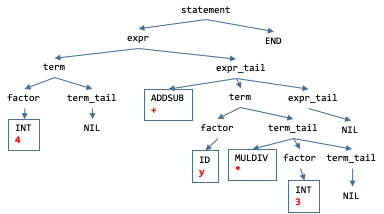

上面的樹狀圖叫做 Parse Tree，直接對應到語法的展開。有一點值得注意的地方，在這個語法裡面，每個 `term` 或 `expr` 都可以算出一個整數值。另外一種圖像表達語法的方式就是 Syntax Tree，如下圖。實作時我們可以只用函數呼叫來達成展開 Expression 的效果，也可以用資料結構建出樹狀圖。接下來就來看程式該如何寫。

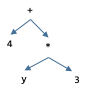

最直接的處理方式就是把每條語法規寫成一個函數。底下是第一個版本的程式碼，稍微對照就會發現，幾乎只要照著語法規則依序呼叫對應的函數，就能完成語法分析。在這個版本裡面我們還沒做真正的運算，只是把讀到的內容依照分析順序用 `printf` 顯示出來。
需要特別注意的是呼叫 `advance()` 的時間點	：只有當我們用 `match` 判斷之後，確定讀取的是我們想要的 Token 之後，才會呼叫 `advance()` 讀取下一個 Token。

In [ ]:
%%writefile E07_02.c
#include <stdio.h>
#include <string.h>
#include <ctype.h>
#include <stdlib.h>
#include "lex.h"

void statement(void);
void expr(void);
void expr_tail(void);
void term(void);
void term_tail(void);
void factor(void);

void statement(void)
{
    if (match(END)) {
        advance();
        // nothing
    } else {
        expr();
        match(END);
        advance();
    }
}
void expr(void)
{
    term();
    expr_tail();
}

void expr_tail(void)
{
    if (match(ADDSUB)){
        printf("ADDSUB: %s\n", getLexeme());
        advance();
        term();
        expr_tail();
    } else {
        // NIL
    }
}
void term(void)
{
    factor();
    term_tail();
}

void term_tail(void)
{
    if (match(MULDIV)) {
        printf("MULDIV: %s\n", getLexeme());
        advance();
        factor();
        term_tail();
    } else {
        // NIL
    }
}
void factor(void)
{
    if (match(INT)) {
        printf("INT: %s\n", getLexeme());
        advance();
    } else if (match(ADDSUB)) {
        printf("ADDSUB: %s\n", getLexeme());
        advance();
        if (match(INT)) {
            printf("INT: %s\n", getLexeme());
            advance();
        } else if (match(ID)) {
            printf("ID: %s\n", getLexeme());
            advance();
        }
    } else if (match(ID)) {
        printf("ID: %s\n", getLexeme());
        advance();
        if (match(ASSIGN)) {
            printf("ASSIGN: %s\n", getLexeme());
            advance();
            expr();
        }
    } else if (match(LPAREN)) {
        printf("LPAREN: %s\n", getLexeme());
        advance();
        expr();
        if (match(RPAREN)) {
            printf("RPAREN: %s\n", getLexeme());
            advance();
        } else {
            printf("Parenthesis mismatched\n");
        }
    }
}

int main(void)
{
    printf(">> ");
    while (strcmp(getLexeme(), "exit")) {
      statement();
      printf(">> ");
    }
    return 0;
}


Writing E07_02.c


In [ ]:
%%shell
gcc -o E07_02 lex_1.c E07_02.c
./E07_02

>> exit
ID: exit
exit
>> 

觀察第一個版本的程式碼，會發現 `expr` 和 `term` 都只有呼叫其他函數，而 `expr_tail` 和 `term_tail` 都是遞迴呼叫，而且是 tail recursion 形式的遞迴呼叫。所謂 tail recursion，是指遞迴呼叫發生在整個函數的最後面，遞迴呼叫之後不會再做任何額外的運算就直接 `return`。這種形式的遞迴有個很大的好處是不用保留 stack 內容， 因為不會再用到，所以每次呼叫都可以重複使用同一塊 stack 空間。符合 tail recursion 的遞迴呼叫都可以直接轉換成迴圈的形式。底下就是合併 `expr` 和 `expr_tail` 以及合併 `term` 和 `term_tail` 之後的新的版本，而且原本的 `expr_tail` 和 `term_tail` 的遞迴也改成迴圈。


In [ ]:
%%writefile E07_03.c

#include <stdio.h>
#include <string.h>
#include <ctype.h>
#include <stdlib.h>
#include "lex.h"

void statement(void);
void expr(void);
void term(void);
void factor(void);

void statement(void)
{
    if (match(END)) {
        advance();
        // nothing
    } else {
        expr();
        match(END);
        advance();
    }
}

void expr(void)
{
    term();
    while (match(ADDSUB)) {
        printf("ADDSUB: %s\n", getLexeme());
        advance();
        term();
    }
}
void term(void) {
    factor();
    while (match(MULDIV)) {
        printf("MULDIV: %s\n", getLexeme());
        advance();
        factor();
    }
}

void factor(void)
{
    if (match(INT)) {
        printf("INT: %s\n", getLexeme());
        advance();
    } else if (match(ADDSUB)) {
        printf("ADDSUB: %s\n", getLexeme());
        advance();
        if (match(INT)) {
            printf("INT: %s\n", getLexeme());
            advance();
        } else if (match(ID)) {
            printf("ID: %s\n", getLexeme());
            advance();
        }
    } else if (match(ID)) {
        printf("ID: %s\n", getLexeme());
        advance();
        if (match(ASSIGN)) {
            printf("ASSIGN: %s\n", getLexeme());
            advance();
            expr();
        }
    } else if (match(LPAREN)) {
        printf("LPAREN: %s\n", getLexeme());
        advance();
        expr();
        if (match(RPAREN)) {
            printf("RPAREN: %s\n", getLexeme());
            advance();
        } else {
            printf("Parenthesis mismatched\n");
        }
    }
}

int main(void)
{
    statement();
    return 0;
}

Overwriting E07_03.c


In [ ]:
%%shell
gcc -o E07_03 lex.c E07_03.c
./E07_03

3+5*9
INT: 3
ADDSUB: +
INT: 5
MULDIV: *
INT: 9



最終版本是要替換掉 `printf`  顯示，把實際該做的運算加進去。首先要把語法相關的函數的回傳值型別都改成 `int`，然後加入數值運算。

底下是其他的函數。`error` 是用來顯示各種類型的錯誤訊息。比較複雜的應該是 `getval` 和 `setval`，這兩個函數是為了處理變數，做法是用一個表格陣列 `Symbol table[TBLSIZE];` 來記錄變數的狀態。對於 Expression 中出現的變數，會先搜尋 `table` 看看是否已有記錄。如果搜尋不到，就當作是初次出現的變數，會直接設定初值並且將變數記錄在 `table` 中。如果 `table` 之中已有記錄，則可以取出其中的值或是覆蓋已有的值。

In [ ]:
%%writefile E07_04.c
#include <stdio.h>
#include <string.h>
#include <ctype.h>
#include <stdlib.h>
#include "lex.h"

#define TBLSIZE 65535
typedef struct {
    char name[MAXLEN];
    int val;
} Symbol;
Symbol table[TBLSIZE];
int sbcount = 0;

void statement(void);
int expr(void);
int term(void);
int factor(void);
int getval(void);
int setval(char*, int);

typedef enum {MISPAREN, NOTNUMID, NOTFOUND, RUNOUT} ErrorType;
void error(ErrorType errorNum);

int getval(void)
{
    int i, retval, found;
    if (match(INT)) {
        retval = atoi(getLexeme());
    } else if (match(ID)) {
        i = 0; found = 0; retval = 0;
        while (i<sbcount && !found) {
            if (strcmp(getLexeme(), table[i].name) == 0) {
                retval = table[i].val;
                found = 1;
                break;
            } else {
                i++;
            }
        }
        if (!found) {
            if (sbcount < TBLSIZE) {
                strcpy(table[sbcount].name,
		getLexeme());
                table[sbcount].val = 0;
                sbcount++;
            } else {
                error(RUNOUT);
            }
        }
    }
    return retval;
}

int setval(char *str, int val)
{
    int i, retval = 0;
    i = 0;
    while (i<sbcount) {
        if (strcmp(str, table[i].name)==0) {
            table[i].val = val;
            retval = val;
            break;
        } else {
            i++;
        }
    }
    return retval;
}

void error(ErrorType errorNum)
{
    switch (errorNum) {
    case MISPAREN:
        fprintf(stderr,
          "Mismatched parenthesis\n");
        break;
    case NOTNUMID:
        fprintf(stderr,
          "Number or identifier expected\n");
        break;
    case NOTFOUND:
        fprintf(stderr,
          "%s not defined\n", getLexeme());
        break;
    case RUNOUT:
        fprintf(stderr,
          "Out of memory\n");
    }
    exit(0);
}

int expr(void)
{
    int retval;
    retval = term();
    while (match(ADDSUB)) {
        if (strcmp(getLexeme(), "+")==0) {
            advance();
            retval += term();
        } else if (strcmp(getLexeme(), "-") ==0) {
            advance();
            retval -= term();
        } else {
            // NIL
        }
    }
    return retval;
}
int term(void)
{
    int retval;
    retval = factor();
    while (match(MULDIV)) {
        if (strcmp(getLexeme(), "*")==0) {
            advance();
            retval *= factor();
        } else if (strcmp(getLexeme(), "/")
		        ==0) {
            advance();
            retval /= factor();
        } else {
            // NIL
        }
    }
    return retval;
}


void statement(void)
{
    int retval;

    if (match(END)) {
        printf(">> ");
        advance();
    } else {
        retval = expr();
        if (match(END)) {
            printf("%d\n", retval);
            printf(">> ");
            advance();
        }
    }
}

int factor(void)
{
    int retval = 0;
    char tmpstr[MAXLEN];

    if (match(INT)) {
        retval = getval();
        advance();
    } else if (match(ID)) {
        retval = getval();
        strcpy(tmpstr, getLexeme());
        advance();
        if (match(ASSIGN)) {
            advance();
            retval = expr();
            retval = setval(tmpstr, retval);
        }
    } else if (match(ADDSUB)) {
        strcpy(tmpstr, getLexeme());
        advance();
        if (match(ID) || match(INT)) {
            retval = getval();
            if (strcmp(tmpstr, "-")==0) {
                retval = -retval;
            }
            advance();
        } else {
            error(NOTNUMID);
        }
    } else if (match(LPAREN)) {
        advance();
        retval = expr();
        if (match(RPAREN)) {
            advance();
        } else {
            error(MISPAREN);
        }
    } else {
        error(NOTNUMID);
    }
    return retval;
}


int main()
{
    printf(">> ");
    while (1) {
        statement();
    }
    return 0;
}


Writing E07_04.c


In [ ]:
%%shell
gcc -o E07_04 lex.c E07_04.c
./E07_04

>> x
0
>> y
0
>> x = 3
3
>> x
3
>> z = (x + y
Mismatched parenthesis


##Syntax Tree

完成了上面的版本之後，我們可以再試試看，改成 建構 Syntax Tree 的版本。

要用到的資料結構最近幾周看過的 Binary Tree
```
typedef struct _Node {
	char lexeme[MAXLEN];
	TokenSet token;
	int val;
	struct _Node *left, *right;
} BTNode;
```

要把前一個版本的每個函數，從原本傳回 `int` ，都改成傳回 `BTNode*` 指標。
先把 Syntax Tree 建好，然後再用 `evaluateTree` 把對應的 Expression 整數值算出來。

底下貼上 `main.c`  最終版程式檔案內容，至於 `lex.c`  `lex.h` 內容則跟前面的一樣。

完整的程式碼也可以從這裡下載：
https://github.com/htchen/calculator_tree

In [ ]:
%%writefile main.c

#include <stdio.h>
#include <string.h>
#include <ctype.h>
#include <stdlib.h>
#include "lex.h"
/*
Something like Python
>> y = 2
>> z = 2
>> x = 3*y + 4/(2*z)
*/
/*
the only type: integer
everything is an expression
  statement   := END | expr END
  expr        := term expr_tail
  expr_tail   := ADDSUB term expr_tail | NIL
  term        := factor term_tail
  term_tail := MULDIV factor term_tail | NIL
  factor      := INT | ADDSUB INT | ADDSUB ID | ID ASSIGN expr | ID | LPAREN expr RPAREN
*/
#define TBLSIZE 65535
typedef struct {
    char name[MAXLEN];
    int val;
} Symbol;
Symbol table[TBLSIZE];
int sbcount = 0;

typedef struct _Node {
    char lexeme[MAXLEN];
    TokenSet token;
    int val;
    struct _Node *left, *right;
} BTNode;

void statement(void);
BTNode* expr(void);
BTNode* term(void);
BTNode* factor(void);
int getval(void);
int setval(char*, int);

typedef enum {MISPAREN, NOTNUMID, NOTFOUND, RUNOUT, NAN} ErrorType;
void error(ErrorType errorNum);

/* create a node without any child */
BTNode* makeNode(TokenSet tok, const char *lexe)
{
    BTNode *node = (BTNode*) malloc(sizeof(BTNode));
    strcpy(node->lexeme, lexe);
    node->token= tok;
    node->val = 0;
    node->left = NULL;
    node->right = NULL;
    return node;
}

/* clean a tree */
void freeTree(BTNode *root)
{
    if (root!=NULL) {
        freeTree(root->left);
        freeTree(root->right);
        free(root);
    }
}

/* print a tree by pre-order */
void printPrefix(BTNode *root)
{
    if (root != NULL) {
        printf("%s ", root->lexeme);
        printPrefix(root->left);
        printPrefix(root->right);
    }
}

/* traverse the syntax tree by pre-order
   and evaluate the underlying expression */
int evaluateTree(BTNode *root)
{
    int retval = 0, lv, rv;
    if (root != NULL) {
        switch (root->token) {
        case ID:
        case INT:
            retval = root->val;
            break;
        case ASSIGN:
        case ADDSUB:
        case MULDIV:
            lv = evaluateTree(root->left);
            rv = evaluateTree(root->right);
            if (strcmp(root->lexeme, "+") == 0)
                retval = lv + rv;
            else if (strcmp(root->lexeme, "-") == 0)
                retval = lv - rv;
            else if (strcmp(root->lexeme, "*") == 0)
                retval = lv * rv;
            else if (strcmp(root->lexeme, "/") == 0) {
                if (rv==0)
                    error(NAN);
                else
                    retval = lv / rv;
            } else if (strcmp(root->lexeme, "=") == 0)
                retval = setval(root->left->lexeme, rv);
            break;
        default:
            retval = 0;
        }
    }
    return retval;
}

int getval(void)
{
    int i, retval, found;

    if (match(INT)) {
        retval = atoi(getLexeme());
    } else if (match(ID)) {
        i = 0;
        found = 0;
        retval = 0;
        while (i<sbcount && !found) {
            if (strcmp(getLexeme(), table[i].name)==0) {
                retval = table[i].val;
                found = 1;
                break;
            } else {
                i++;
            }
        }
        if (!found) {
            if (sbcount < TBLSIZE) {
                strcpy(table[sbcount].name, getLexeme());
                table[sbcount].val = 0;
                sbcount++;
            } else {
                error(RUNOUT);
            }
        }
    }
    return retval;
}
int setval(char *str, int val)
{
    int i, retval = 0;
    i = 0;
    while (i<sbcount) {
        if (strcmp(str, table[i].name)==0) {
            table[i].val = val;
            retval = val;
            break;
        } else
            i++;
    }
    return retval;
}
//  expr        := term expr_tail
//  expr_tail   := ADDSUB term expr_tail | NIL
BTNode* expr(void)
{
    BTNode *retp, *left;
    retp = left = term();
    while (match(ADDSUB)) { // tail recursion => while
        retp = makeNode(ADDSUB, getLexeme());
        advance();
        retp->right = term();
        retp->left = left;
        left = retp;
    }
    return retp;
}

//  term      := factor term_tail
//  term_tail := MULDIV factor term_tail | NIL
BTNode* term(void)
{
    BTNode *retp, *left;
    retp = left = factor();
    while (match(MULDIV)) { // tail recursion => while
        retp = makeNode(MULDIV, getLexeme());
        advance();
        retp->right = factor();
        retp->left = left;
        left = retp;
    }
    return retp;
}
BTNode* factor(void)
{
    BTNode* retp = NULL;
    char tmpstr[MAXLEN];

    if (match(INT)) {
        retp =  makeNode(INT, getLexeme());
        retp->val = getval();
        advance();
    } else if (match(ID)) {
        BTNode* left = makeNode(ID, getLexeme());
        left->val = getval();
        strcpy(tmpstr, getLexeme());
        advance();
        if (match(ASSIGN)) {
            retp = makeNode(ASSIGN, getLexeme());
            advance();
            retp->right = expr();
            retp->left = left;
        } else
            retp = left;
    } else if (match(ADDSUB)) {
        strcpy(tmpstr, getLexeme());
        advance();
        if (match(ID) || match(INT)) {
            retp = makeNode(ADDSUB, tmpstr);
            if (match(ID)) retp->right = makeNode(ID, getLexeme());
            else retp->right = makeNode(INT, getLexeme());
            retp->right->val = getval();
            retp->left = makeNode(INT, "0");
            retp->left->val = 0;
            advance();
        } else
            error(NOTNUMID);
    } else if (match(LPAREN)) {
        advance();
        retp = expr();
        if (match(RPAREN))
            advance();
        else
            error(MISPAREN);
    } else
        error(NOTNUMID);
    return retp;
}

void error(ErrorType errorNum)
{
    switch (errorNum) {
    case MISPAREN:
        fprintf(stderr, "Mismatched parenthesis\n");
        break;
    case NOTNUMID:
        fprintf(stderr, "Number or identifier expected\n");
        break;
    case NOTFOUND:
        fprintf(stderr, "%s not defined\n", getLexeme());
        break;
    case RUNOUT:
        fprintf(stderr, "Out of memory\n");
        break;
    case NAN:
        fprintf(stderr, "Not a number\n");
    }
    exit(0);
}

void statement(void)
{
    BTNode* retp;

    if (match(END)) {
        printf(">> ");
        advance();
    } else {
        retp = expr();
        if (match(END)) {
            printf("%d\n", evaluateTree(retp));
            printPrefix(retp);
            printf("\n");
            freeTree(retp);

            printf(">> ");
            advance();
        }
    }
}

int main()
{
    printf(">> ");
    while (1) {
        statement();
    }
    return 0;
}



Overwriting main.c


In [ ]:
%%shell
gcc -o calculator lex.c main.c
./calculator

2*3 + 4*5 + 6

          +
        /  \
       +    6
      /  \
     *    *
    / \   / \
    2  3  4  5